In [102]:
! git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


In [103]:
! git clone https://github.com/timojl/clipseg 

fatal: destination path 'clipseg' already exists and is not an empty directory.


In [104]:
! pip install diffusers -q

In [105]:
! pip install transformers -q -UU ftfy gradio  

In [106]:
! pip install git+https://github.com/openai/CLIP.git -q

  Preparing metadata (setup.py) ... done


In [107]:
from huggingface_hub import notebook_login

notebook_login()

In [108]:
%cd clipseg

/content/clipseg


In [109]:
! ls

datasets	     metrics.py		      score.py
environment.yml      models		      setup.py
evaluation_utils.py  overview.png	      supplementary.pdf
example_image.jpg    Quickstart.ipynb	      Tables.ipynb
experiments	     README.md		      training.py
general_utils.py     sample_rd64.png	      Visual_Feature_Engineering.ipynb
LICENSE		     sample_rd64_refined.png  weights


In [110]:
import torch
import requests
import cv2 
from models.clipseg import CLIPDensePredT
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

In [111]:
from io import BytesIO

from torch import autocast
import requests
import PIL
import torch
from diffusers import StableDiffusionInpaintPipeline as StableDiffusionInpaintPipeline

In [112]:
#! git lfs install

In [113]:
# load model
model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval();


In [114]:
# non-strict, because we only stored decoder weights (not CLIP weights)
model.load_state_dict(torch.load('/content/clipseg/weights/rd64-uni.pth', map_location=torch.device('cuda')), strict=False);


In [115]:
device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/diffusers/pipelines/pipeline_utils.py:681: FutureWarning: You are using a legacy checkpoint for inpainting with Stable Diffusion, therefore we are loading the <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> class instead of <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'>. For better inpainting results, we strongly suggest using Stable Diffusion's official inpainting checkpoint: https://huggingface.co/runwayml/stable-diffusion-inpainting instead or adapting your checkpoint CompVis/stable-diffusion-v1-4 to the format of https://huggingface.co/runwayml/stable-diffusion-inpainting. Note that we do not actively maintain the {StableDiffusionInpaintPipelineLegacy} class and will likely remove it in version 1.0.0.
  deprecate("StableDiffusionInpaintPipelineLegacy", "1.0.0", deprecation_message, standard_warn=False)
C

In [116]:
# or load from URL...
image_url = 'https://okmagazine.ge/wp-content/uploads/2021/04/00-promo-rob-pattison-1024x1024.jpg' #'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimage.tmdb.org%2Ft%2Fp%2Foriginal%2F72xYNWRTVMDiKVa6SVu6EY0S9Np.jpg' #'https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png' 
input_image = Image.open(requests.get(image_url, stream=True).raw)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((512, 512)),
])
img = transform(input_image).unsqueeze(0)

In [117]:
%cd ..

/content


In [118]:
input_image.convert("RGB").resize((512, 512)).save("init_image.png", "PNG")

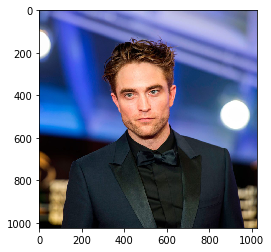

In [119]:
from matplotlib import pyplot as plt
plt.imshow(input_image, interpolation='nearest')
plt.show()

In [140]:
prompts = ['area outside of face']

In [141]:

# predict
with torch.no_grad():
    preds = model(img.repeat(len(prompts),1,1,1), prompts)[0]


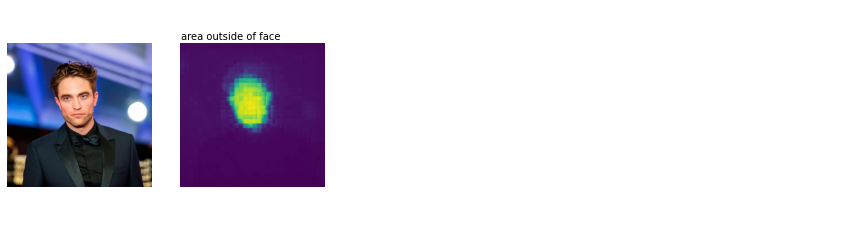

In [142]:
# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(input_image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompts[i]) for i in range(len(prompts))];

In [143]:
filename = f"mask.png"
plt.imsave(filename,torch.sigmoid(preds[0][0]))

In [144]:
img2 = cv2.imread(filename)

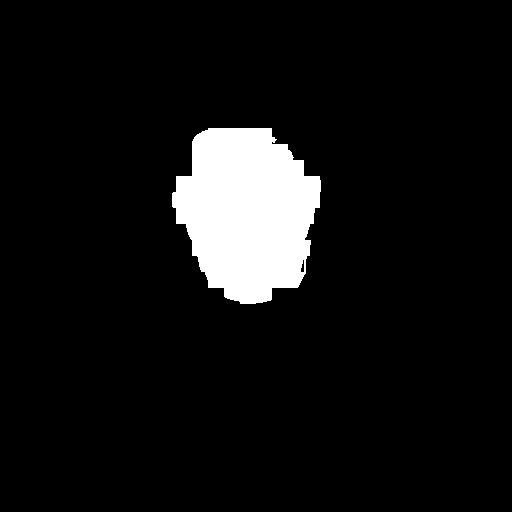

In [145]:
gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# For debugging only:
cv2.imwrite(filename,bw_image)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)

In [146]:
init_image = Image.open('init_image.png')
mask = Image.open('mask.png')

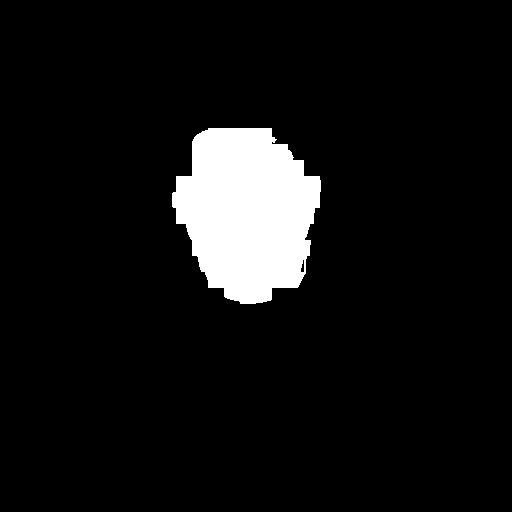

In [147]:
mask

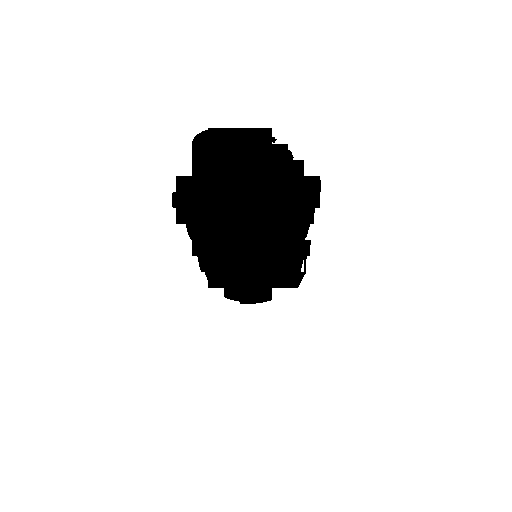

In [158]:
import numpy as np
matrix = 255 - np.asarray(mask)
newmask = Image.fromarray(matrix)
newmask

In [159]:
with autocast("cuda"):
    tmpval = pipe(prompt="be a professor in the media lab", init_image=init_image, mask_image=newmask, strength=0.8)

/usr/local/lib/python3.8/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_inpaint_legacy.py:607: FutureWarning: The `init_image` argument is deprecated and will be removed in version 0.14.0. Please use `image` instead of `init_image`.
  init_image = deprecate("init_image", "0.14.0", message, take_from=kwargs)


  0%|          | 0/40 [00:00<?, ?it/s]

In [160]:
dir(tmpval)

['__annotations__',
 '__class__',
 '__contains__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'images',
 'items',
 'keys',
 'move_to_end',
 'nsfw_content_detected',
 'pop',
 'popitem',
 'setdefault',
 'to_tuple',
 'update',
 'values']

In [161]:
tmpval.keys()

odict_keys(['images', 'nsfw_content_detected'])

In [164]:
with autocast("cuda"):
    images = pipe(prompt="be a professor in the media lab", init_image=init_image, mask_image=newmask, strength=0.8).images


  0%|          | 0/40 [00:00<?, ?it/s]

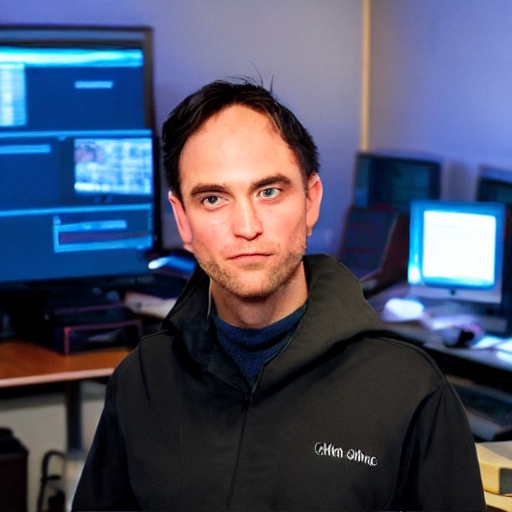

In [165]:
images[0]